In [1]:
%config Completer.use_jedi = False

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
!pwd

/Users/sanghyub/space/TIL/Kaggling


In [11]:
train_data_path = join('', 'train.csv')
sub_data_path = join('', 'test.csv')

In [4]:
train_data_path

'train.csv'

### 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.  

ID : 집을 구분하는 번호  
date : 집을 구매한 날짜  
price : 타겟 변수인 집의 가격  
bedrooms : 침실의 수  
bathrooms : 침실당 화장실 개수  
sqft_living : 주거 공간의 평방 피트  
sqft_lot : 부지의 평방 피트  
floors : 집의 층 수  
waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)  
view : 집이 얼마나 좋아 보이는지의 정도  
condition : 집의 전반적인 상태  
grade : King County grading 시스템 기준으로 매긴 집의 등급  
sqft_above : 지하실을 제외한 평방 피트  
sqft_basement : 지하실의 평방 피트  
yr_built : 집을 지은 년도  
yr_renovated : 집을 재건축한 년도  
zipcode : 우편번호  
lat : 위도  
long : 경도  
sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)  
sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)  

In [12]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim: {}'.format(data.shape))
print('sub data dim: {}'.format(sub.shape))

train data dim: (15035, 21)
sub data dim: (6468, 20)


In [13]:
y = data['price']

del data['price']

In [14]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

In [15]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [107]:
data.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000
mean,1.452955,2.116042,7.551722,8.990284,1.495140,0.005254,0.116264,1.473678,7.659164,7.396348,2.530451,1971.055016,0.322660,98077.897968,47.560121,-122.213786,7.540336,8.961225
std,0.213407,0.770018,0.424418,0.902629,0.540183,0.060121,0.362494,0.140245,1.174422,0.427322,3.170984,29.372398,1.532315,53.489890,0.138615,0.140833,0.327404,0.813163
min,0.000000,0.000000,5.673323,6.255750,1.000000,0.000000,0.000000,0.693147,1.000000,5.673323,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,5.991465,6.480045
25%,1.386294,1.750000,7.266129,8.525360,1.000000,0.000000,0.000000,1.386294,7.000000,7.090910,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,7.307202,8.537192
50%,1.386294,2.250000,7.557473,8.938138,1.500000,0.000000,0.000000,1.386294,7.000000,7.353082,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.230000,7.518064,8.938663
75%,1.609438,2.500000,7.844241,9.276783,2.000000,0.000000,0.000000,1.609438,8.000000,7.701200,6.329721,1997.000000,0.000000,98117.000000,47.678100,-122.125000,7.771067,9.218904
max,3.526361,8.000000,9.513477,14.317110,3.500000,0.693147,1.609438,1.791759,13.000000,9.149634,8.480737,2015.000000,7.608871,98199.000000,47.777600,-121.315000,8.734077,13.677628


## Preprocessing

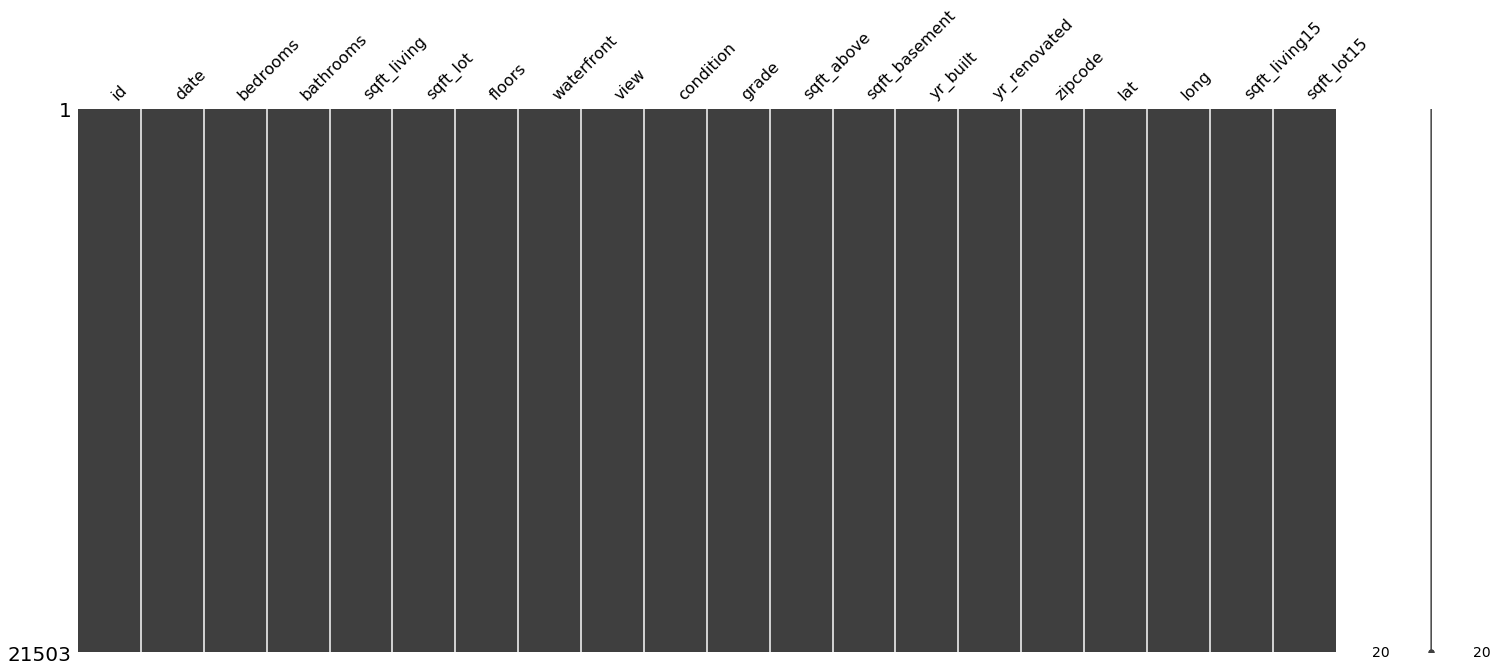

In [16]:
msno.matrix(data)

In [17]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [19]:
data.isnull().sum()

id               0
date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [21]:
data.shape

(21503, 20)

결측치 없음!

In [23]:
train_len

15035

In [25]:
data['date']

0       20141013T000000
1       20150225T000000
2       20150218T000000
3       20140627T000000
4       20150115T000000
5       20150403T000000
6       20140527T000000
7       20140528T000000
8       20141007T000000
9       20150312T000000
10      20150124T000000
11      20140731T000000
12      20140529T000000
13      20141205T000000
14      20150424T000000
15      20140514T000000
16      20140826T000000
17      20140516T000000
18      20141120T000000
19      20141103T000000
20      20140626T000000
21      20141201T000000
22      20141110T000000
23      20140624T000000
24      20141110T000000
25      20141203T000000
26      20140613T000000
27      20141230T000000
28      20150213T000000
29      20140620T000000
             ...       
6438    20140801T000000
6439    20140617T000000
6440    20140509T000000
6441    20150331T000000
6442    20150227T000000
6443    20140711T000000
6444    20140825T000000
6445    20141209T000000
6446    20150217T000000
6447    20140811T000000
6448    20141015

In [26]:
sub_id = data['id'][train_len:]
del data['id']
data['date'] = data['date'].apply(lambda x: str(x[:6])).astype(str)

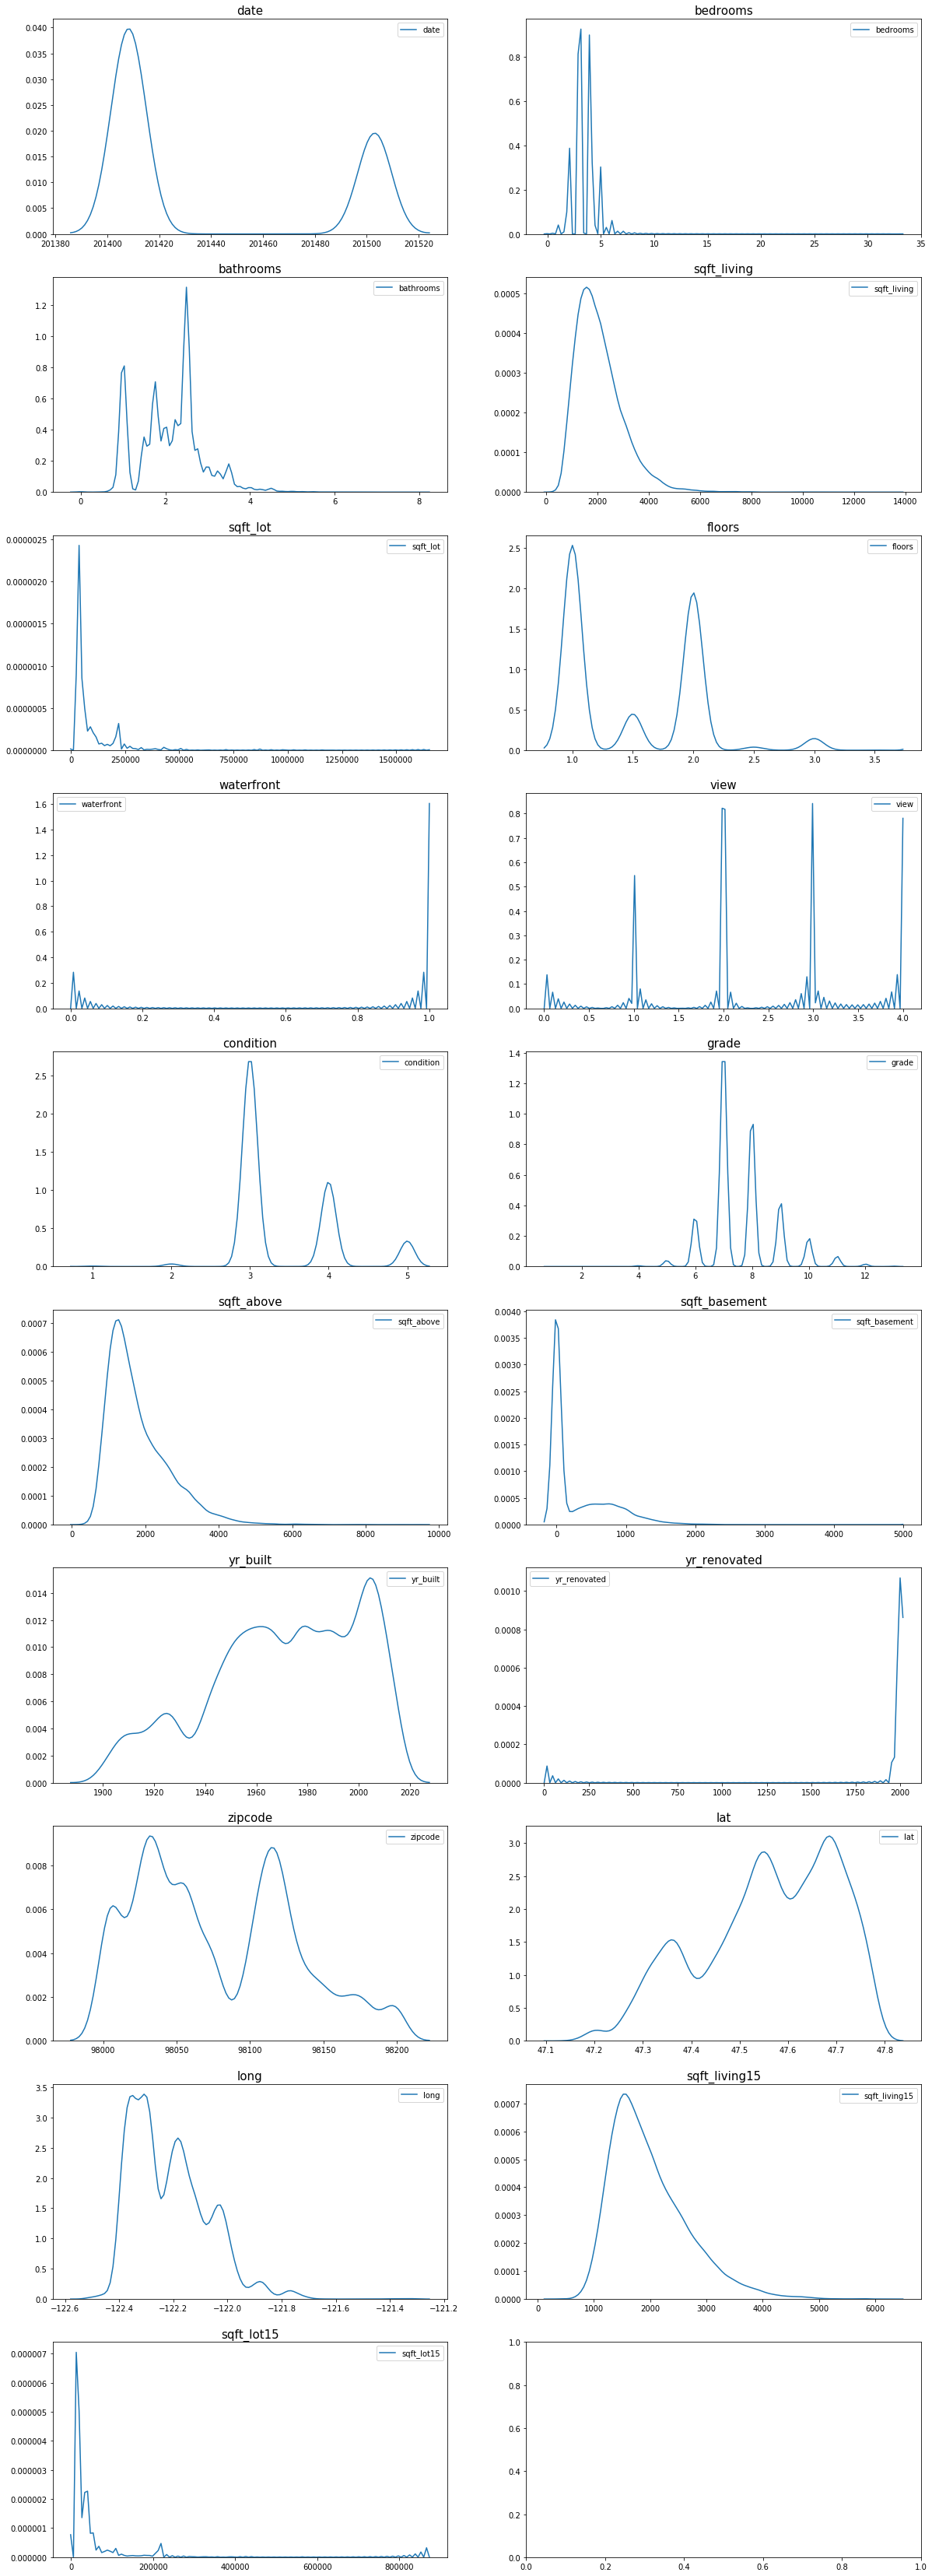

In [27]:
fig, ax = plt.subplots(10, 2, figsize= (20,60))

count = 0
columns = data.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax = ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19:
            break

### skewness가 1보다 큰 column들을 모아보자

In [29]:
from scipy.stats import skew

In [44]:
data.columns

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [47]:
skew(data.bathrooms)

0.5106170705565339

In [56]:
columns = []
for i in data.columns:
    columns.append(i)
    print(columns)

['date']
['date', 'bedrooms']
['date', 'bedrooms', 'bathrooms']
['date', 'bedrooms', 'bathrooms', 'sqft_living']
['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot']
['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors']
['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront']
['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view']
['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition']
['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade']
['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above']
['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement']
['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfron

In [58]:
columns = columns[1:]

In [59]:
columns

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [64]:
skew(data['{}'.format(columns[1])])

0.5106170705565339

In [76]:
skew_columns = []
for i in range(0,18):
    print('Skewness of Column {}:'.format(columns[i]), skew(data['{}'.format(columns[i])]))
    if skew(data['{}'.format(columns[i])]) > 1:
        skew_columns.append(columns[i])
    

Skewness of Column bedrooms: 1.9832464638129854
Skewness of Column bathrooms: 0.5106170705565339
Skewness of Column sqft_living: 1.471311080614517
Skewness of Column sqft_lot: 13.062503126146359
Skewness of Column floors: 0.613455960500885
Skewness of Column waterfront: 11.354641501906764
Skewness of Column view: 3.3918273345307908
Skewness of Column condition: 1.0365742973679386
Skewness of Column grade: 0.7704762377438158
Skewness of Column sqft_above: 1.4459071958957095
Skewness of Column sqft_basement: 1.5762346349654182
Skewness of Column yr_built: -0.47169661449727346
Skewness of Column yr_renovated: 4.53878868243986
Skewness of Column zipcode: 0.40737709569492647
Skewness of Column lat: -0.4867959256671349
Skewness of Column long: 0.8839867857774448
Skewness of Column sqft_living15: 1.1065166359584202
Skewness of Column sqft_lot15: 9.508526503183713


### 한쪽으로 쏠린 특성들이 발견되므로, log-scaling을 통해서 데이터 분포를 정규분포에 가깝게 만들어 보자

In [77]:
skew_columns

['bedrooms',
 'sqft_living',
 'sqft_lot',
 'waterfront',
 'view',
 'condition',
 'sqft_above',
 'sqft_basement',
 'yr_renovated',
 'sqft_living15',
 'sqft_lot15']

In [82]:
len(skew_columns)

11

In [78]:
for c in skew_columns:
    data[c] = np.log1p(data[c].values)

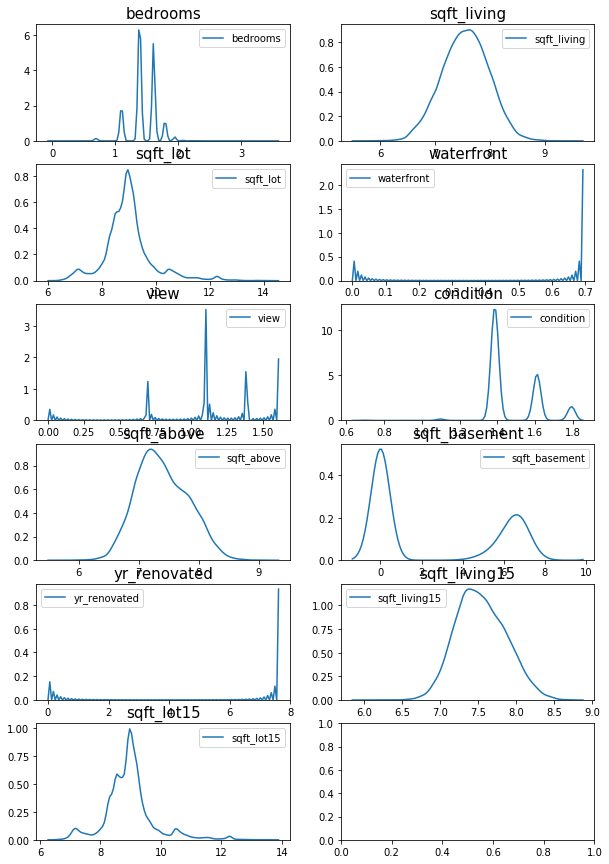

In [89]:
fig, ax = plt.subplots(6, 2, figsize=(10, 15))

count = 0
for row in range(6):
    for col in range(2):
        if count == 11:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1

#### skewness는 어느정도 잡혔지만 뾰족한 분포들 확인

In [95]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

### Modeling

In [100]:
gboost = GradientBoostingRegressor(random_state=42)
xgboost = xgb.XGBRegressor(random_state=42)
lightgbm = lgb.LGBMRegressor(random_state=42)

models = [{'model': gboost, 'name':'GradientBoosting'},
         {'model': xgboost, 'name':'XGBoost'},
         {'model': lightgbm,'name':'LightGBM'}]

In [101]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                             kf=kfold))


In [102]:
get_cv_score(models)

Model GradientBoosting CV score : 0.8573
Model XGBoost CV score : 0.8539
Model LightGBM CV score : 0.8749


## submission

In [103]:
def AveragingBlending(models, x, y, sub_x):
    for m in models :
        m['model'].fit(x.values, y)
        
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models])
    return np.mean(predictions, axis=1)

In [104]:
y_pred = AveragingBlending(models, x, y, sub)

In [105]:
sub = pd.DataFrame(data={'id':sub_id, 'price':y_pred})

In [106]:
sub.to_csv('baseline_submission.csv', index=False)